In [25]:
from platform import python_version
print(python_version())

3.9.16


In [24]:
%matplotlib inline
#%reset
import sys
import numpy as np
import os
import math
import cv2
import shutil
import time
import random
import matplotlib.image as img
import tensorflow as tf
import itertools
from PIL import Image


# ensure we are training on GPU
# print(tf.__version__)
# print(tf.__file__)
# print(tf.config.list_physical_devices())
#print(tf.config.list_physical_devices('GPU'))

from tensorflow import keras
from keras.callbacks import EarlyStopping
#from IPython.display import Image, display
import matplotlib.pyplot as plt

ImageDataGenerator = keras.preprocessing.image.ImageDataGenerator

In [26]:
# set random seed to ensure determinism for hyperparameter comparison, without shuffling
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
tf.config.experimental.enable_op_determinism()

## Base image directory path

In [27]:
BASE_IMAGE_DIR = "C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages"

## Set up data directories to cleanse data

Found 12488 images in the cat directory.
Found 12487 images in the dog directory.


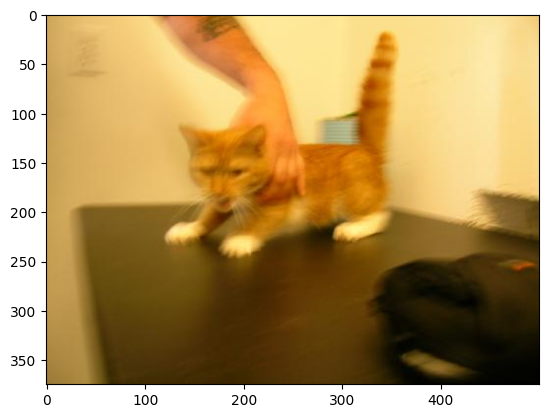

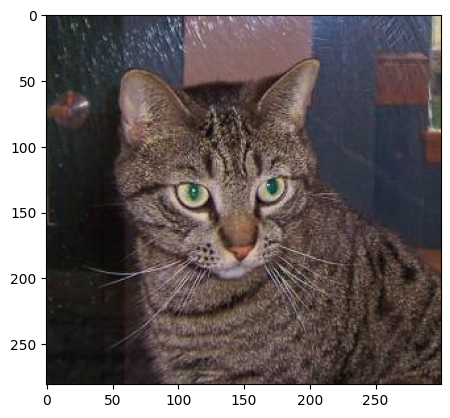

In [28]:
CAT_IMAGE_DIR = os.path.join(BASE_IMAGE_DIR, 'Cat')
DOG_IMAGE_DIR = os.path.join(BASE_IMAGE_DIR, 'Dog')
CORRUPTED_IMAGE_DIR = os.path.join(BASE_IMAGE_DIR, 'corrupted')
TRAINED_MODELS_DIR = os.path.join(BASE_IMAGE_DIR, 'models')
SAVE_DIR = r"C:\dev\programming_2023\cnn_project\training_plots"

if not os.path.exists(CORRUPTED_IMAGE_DIR):
    print("Creating {}".format(CORRUPTED_IMAGE_DIR))
    os.makekdirs(CORRUPTED_IMAGE_DIR)
    
if not os.path.exists(TRAINED_MODELS_DIR):
    print("Creating {}".format(TRAINED_MODELS_DIR))
    os.makekdirs(TRAINED_MODELS_DIR)

    
print("Found {} images in the cat directory.".format(len(os.listdir(CAT_IMAGE_DIR))))
print("Found {} images in the dog directory.".format(len(os.listdir(DOG_IMAGE_DIR))))

# display the first 2 images of the cat directory as a santity check
first_images = os.listdir(CAT_IMAGE_DIR)[:2]
for image in first_images:
    test_img_path = "{}/{}".format(CAT_IMAGE_DIR, image)
    test_img =  cv2.cvtColor(cv2.imread(test_img_path), cv2.COLOR_BGR2RGB)
    
    plt.imshow(test_img)
    plt.show()

## Remove corrupted images

In [29]:
cat_images = os.listdir(CAT_IMAGE_DIR)
for image in cat_images:
    test_img_path = "{}/{}".format(CAT_IMAGE_DIR, image)
    try:
        im = Image.open(test_img_path)
    except:
        print("Found corrupted image: {}. Moving to: {} ".format(test_img_path, CORRUPTED_IMAGE_DIR))
        corrupted_path = "{}/{}".format(CORRUPTED_IMAGE_DIR, image)
        os.rename(test_img_path, corrupted_path)
        continue

dog_images = os.listdir(DOG_IMAGE_DIR)
for image in dog_images:
    test_img_path = "{}/{}".format(DOG_IMAGE_DIR, image)
    try:
        im = Image.open(test_img_path)
    except:
        print("Found corrupted image: {}. Moving to: {} ".format(test_img_path, CORRUPTED_IMAGE_DIR))
        corrupted_path = "{}/{}".format(CORRUPTED_IMAGE_DIR, image)
        os.rename(test_img_path, corrupted_path)
        continue

## Parameterized class for image classifier to train and test various hyperparameters

In [30]:
class CatDogImageClassifier():
    def __init__(
        self,
        model_name,
        batch_size,
        activation_function, # currently used in the architecture params
        loss_function,
        epochs,
        layer_configs,
        dropout_rate=None
    ):
        self.model_name=model_name
        self.batch_size=batch_size
        self.activation_function=activation_function
        self.loss_function=loss_function
        self.epochs=epochs
        self.layer_configs=layer_configs
        self.dropout_rate=dropout_rate
        
        self.model=None
        self.acc=None
        self.validation_acc=None
        self.loss=None
        self.validation_loss=None
        self.results=None
        self.train_time=None
        
    def build(self):
        
        print("Building model: {}...".format(self.model_name))
        self.model=keras.models.Sequential()
        
        # build the model dynamically based on the layer configs
        for index, layer_config in enumerate(self.layer_configs):
            
            layer_type = layer_config["type"]

            if layer_type == "Conv2D":
                
                # if this is the first layer, we need to specifc the input shape
                if index == 0:
                    conv2d_layer = keras.layers.Conv2D(
                        layer_config["filters"],
                        layer_config["kernel_size"],
                        activation=self.activation_function,
                        padding="same",
                        input_shape=(256, 256,3)
                    )
                else:
                    conv2d_layer = keras.layers.Conv2D(
                        layer_config["filters"],
                        layer_config["kernel_size"],
                        activation=self.activation_function,
                        padding="same",
                    )  
                    
                self.model.add(conv2d_layer)
                    
            elif layer_type == "MaxPooling2D":
                self.model.add(
                    keras.layers.MaxPooling2D(
                        layer_config["pool_size"]
                    )
                )

            elif layer_type == "Dropout":
                
                # class-level dropout rate takes precedence
                if self.dropout_rate is None:
                    self.model.add(keras.layers.Dropout(
                        layer_config["rate"]
                        )
                    )
                else:
                    print("Using dropout rate: {}".format(self.dropout_rate))
                    self.model.add(keras.layers.Dropout(
                        self.dropout_rate
                        )
                    )

            elif layer_type == "Flatten":
                self.model.add(keras.layers.Flatten())

            elif layer_type == "Dense":
                self.model.add(keras.layers.Dense(
                    units=layer_config["units"],
                    activation=layer_config["activation"]
                ))
                
                              
        self.model.summary()
        
        print("Compiling model...")
        
        self.model.compile(
            loss=self.loss_function,
            optimizer=keras.optimizers.Adamax(learning_rate=0.001),
            metrics=['acc']
        )
        
    def train(self, image_dir):

        start = time.time()
        
        if self.model is None:
            raise Exception("Model is not yet build. Call the build() before calling train()")
        
        # expect the labels in 2 image directories
        subdirs = os.listdir(image_dir)
        
        if not 'Cat' in subdirs or not 'Dog' in subdirs:
            raise Exception("Could not find Cat and/or Dog image directory in {}".format(image_dir))
            
        # warn if we don't find a GPU to train on
        if len(tf.config.list_physical_devices('GPU')) < 1:
            print("No GPU found, training on CPU")
            print("WARNING: Training on CPU not advised.")
        
        
        base_generator = ImageDataGenerator(
            rescale=1/255,
            validation_split=.2
        )
        
        # TODO explore chaging these
        height, width=(256, 256)
        
        train_dataset = base_generator.flow_from_directory(
            image_dir,
            target_size=(height, width),
            classes=('Cat', 'Dog'),
            batch_size=self.batch_size,
            subset='training',
        )

        validation_dataset = base_generator.flow_from_directory(
            image_dir,
            target_size=(height, width),
            classes=('Cat', 'Dog'),
            batch_size=self.batch_size,
            subset='validation',
        )
        
        
        # if our validation loss isn't improving, stop training
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        
        self.results = self.model.fit(
            train_dataset,
            validation_data=validation_dataset,
            workers=20,
            epochs=self.epochs
        )
        
        self.train_time = time.time() - start
        
        # set training metrics
        self.accuracy = self.results.history['acc']
        self.validation_acc = self.results.history['val_acc']
        self.loss = self.results.history['loss']
        self.validation_loss = self.results.history['val_loss']
        
        save_dir = "{}/{}/{}".format(image_dir, "models", self.model_name)
        print("Trained model. Attempting to save to: {}".format(save_dir))
        
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
            
        self.model.save(save_dir)
        
    def plot_results(self, save_dir=None):
        
        if self.results is None:
            raise Exception("No training results.")
        
        
        epochs = self.results.epoch
        
        fig, ax = plt.subplots(1, 2, figsize=(20,6))

        # plot accuracy
        ax[0].set_title("{}: Accuracy".format(self.model_name))
        ax[0].plot(epochs, self.accuracy, label='Training accuracy')
        ax[0].plot(epochs, self.validation_acc, label='Validation accuracy')
        ax[0].set_xlabel("Epoch")
        ax[0].set_xticks(epochs)
        ax[0].set_ylabel("Accuracy")
        ax[0].legend()

        # plot loss
        ax[1].set_title("{}: Loss".format(self.model_name))
        ax[1].plot(epochs, self.loss, label='Training loss')
        ax[1].plot(epochs, self.validation_loss, label='Validation loss')
        ax[1].set_xlabel("Epoch")
        ax[1].set_xticks(epochs)
        ax[1].set_ylabel("Loss")
        ax[1].legend()
        
        if save_dir is not None:
            path = "{}/{}.png".format(save_dir, self.model_name)
            plt.savefig(path)

        plt.show()

        
        

## Define the paramters based on systematic parameter sweep 

In [8]:
best_config = [{'type': 'Conv2D', 'filters': 32, 'kernel_size': (5, 5)}, 
               {'type': 'MaxPooling2D', 'pool_size': (3, 3)},
               {'type': 'Conv2D', 'filters': 64, 'kernel_size': (5, 5)}, 
               {'type': 'MaxPooling2D', 'pool_size': (2, 2)}, 
               {'type': 'Dropout', 'rate': 0.38271112338695834}, 
               {'type': 'Conv2D', 'filters': 64, 'kernel_size': (3, 3)}, 
               {'type': 'MaxPooling2D', 'pool_size': (2, 2)}, 
               {'type': 'Dropout', 'rate': 0.2910111832058714},
               {'type': 'Conv2D', 'filters': 64, 'kernel_size': (5, 5)}, 
               {'type': 'MaxPooling2D', 'pool_size': (2, 2)}, 
               {'type': 'Dropout', 'rate': 0.2985760448907449}, 
               {'type': 'Flatten'},
               {'type': 'Dense', 'units': 64, 'activation': 'relu'}, 
               {'type': 'Dense', 'units': 256, 'activation': 'sigmoid'},
               {'type': 'Dense', 'units': 2, 'activation': 'softmax'}
              ]

best_activation_function = "relu"
best_batch_size = 30
best_loss_function = "binary_crossentropy"
#best_dropout_rate = 0.9
epochs_to_train = 30

best_network = CatDogImageClassifier(
    model_name="best_classifier",
    batch_size=best_batch_size,
    activation_function=best_activation_function,
    loss_function=best_loss_function,
    layer_configs=best_config,
    epochs=epochs_to_train
    
)

In [9]:
best_network.build()
best_network.train(BASE_IMAGE_DIR)

Building model: best_classifier...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 42, 42, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 42, 42, 64)        0         
                                                                 
 conv2d_2 (Conv2D)   

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/best_classifier\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/best_classifier\assets


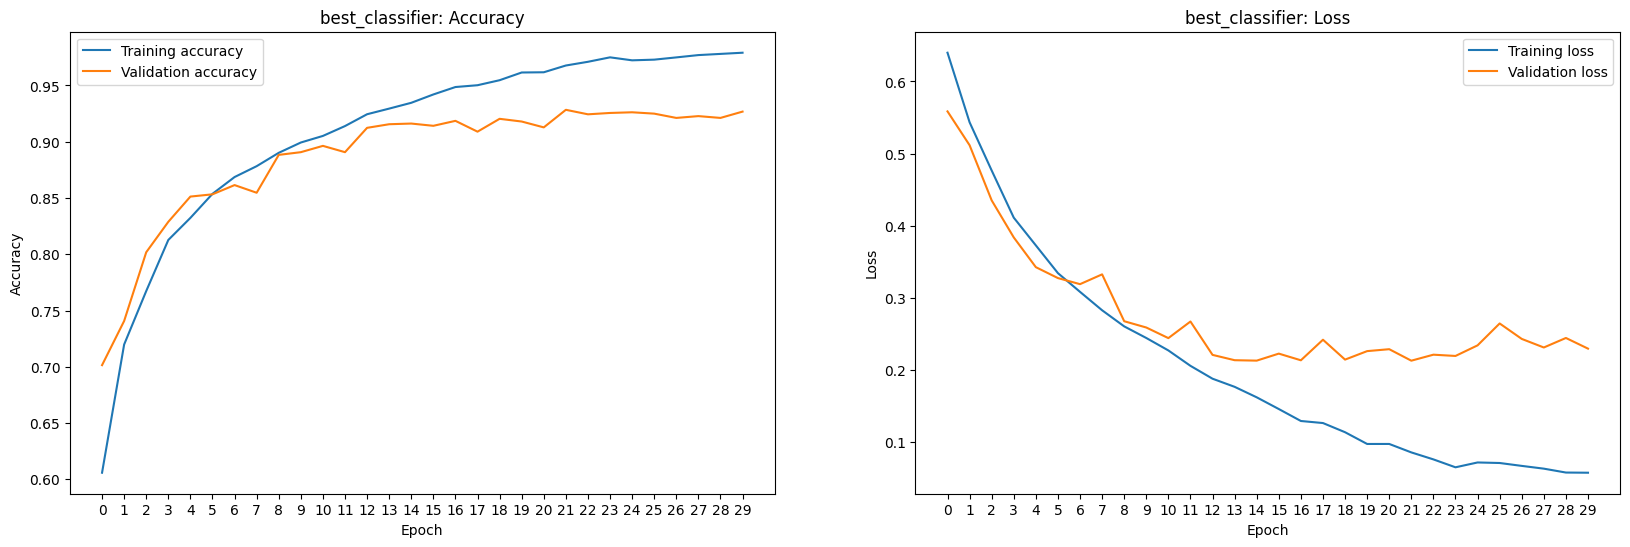

In [10]:
best_network.plot_results(save_dir=SAVE_DIR)

### Hyperparameter tuning - sweep architecture and optimization models

In [31]:
# randomly generate a network configuration
def generate_random_layer_config(layer_type):
    if layer_type == "Conv2D":
        return {
            "type": layer_type,
            "filters": random.choice([16, 32, 64, 128]),
            "kernel_size": random.choice([(3, 3), (5, 5)])
        }

    elif layer_type == "MaxPooling2D":
        return {
            "type": layer_type,
            "pool_size": random.choice([(2, 2), (3, 3)])
        }

    elif layer_type == "Dropout":
        return {
            "type": layer_type,
            "rate": random.uniform(0.5, 0.9)
        }

    elif layer_type == "Flatten":
        return {
            "type": layer_type
        }

    elif layer_type == "Dense":
        return {
            "type": layer_type,
            "units": random.choice([64, 128, 256, 512]),
            "activation": random.choice(["relu", "sigmoid", "tanh"])
        }


def generate_constrained_layer_config_list():
    layer_list = []

    # randomly choose the number of convolutional blocks
    num_conv_blocks = random.randint(1, 4)

    # ensure any conv layer is followed by max pooling layers
    for _ in range(num_conv_blocks):
        layer_list.append(generate_random_layer_config("Conv2D"))
        layer_list.append(generate_random_layer_config("MaxPooling2D"))

        # optionally add dropout layers after MaxPooling2D layers
        if random.random() < 0.5:
            layer_list.append(generate_random_layer_config("Dropout"))

    # add a Flatten layer before the first Dense layer
    layer_list.append(generate_random_layer_config("Flatten"))

    # randomly choose the number of dense layers (excluding the last one)
    num_dense_layers = random.randint(0, 2)

    for _ in range(num_dense_layers):
        layer_list.append(generate_random_layer_config("Dense"))

    # The last layer is Dense with softmax activation
    layer_list.append({
        "type": "Dense",
        "units": 2,
        "activation": "softmax"
    })

    return layer_list

In [32]:
# define an function to sweep architecutre params
def sweep_architecture_params(image_dir, n_trials, other_params):
    best_validation_acc = 0
    best_config = None

    for trial in range(n_trials):
        config = generate_constrained_layer_config_list()
        print("Testing architecture config (trial {}): {}".format(trial + 1, config))

        model = CatDogImageClassifier(
            model_name="architecture_sweep",
            batch_size=other_params["batch_size"],
            activation_function=other_params["activation_function"],
            loss_function=other_params["loss_function"],
            epochs=other_params["epochs"],
            layer_configs=config
        )

        try:
            model.build()
            model.train(image_dir)
            model.plot_results()
        except Exception as e:
            print("Failed to train: {}".format(e))
            continue

        # grab the highest-achieved validation accuracy
        current_validation_acc = max(model.validation_acc)

        if current_validation_acc > best_validation_acc:
            best_validation_acc = current_validation_acc
            best_config = config

        print("Current best validation accuracy: ", best_validation_acc)

    print("Best config: {}".format(best_config))
    return best_config


# define a function to sweep non-config params - (run after we decided on overall architecture)
def grid_search(image_dir, layer_configs, activation_functions, batch_sizes, loss_functions, epochs_list):

    # Generate all combinations of parameters
    param_combinations = list(itertools.product(activation_functions, batch_sizes, loss_functions, epochs_list))

    results = []

    for activation_function, batch_size, loss_function, epoch in param_combinations:
        model_name = f"model_{activation_function}_{batch_size}_{loss_function}_{epoch}"
        print(f"Training model: {model_name}")

        # create and build the model with the current parameter combination
        classifier = CatDogImageClassifier(
            model_name=model_name,
            batch_size=batch_size,
            activation_function=activation_function,
            loss_function=loss_function,
            epochs=epoch,
            layer_configs=layer_configs,
            dropout_rate=None
        )

        try:
            classifier.build()
            classifier.train(image_dir)
        except Exception as e:
            print("Failed to train network: {}. {}".format(model_name, e))

        # Append the results to the results list
        results.append({
            'model_name': model_name,
            'activation_function': activation_function,
            'batch_size': batch_size,
            'loss_function': loss_function,
            'epochs': epoch,
            'accuracy': classifier.accuracy,
            'validation_accuracy': classifier.validation_acc,
            'loss': classifier.loss,
            'validation_loss': classifier.validation_loss
        })
        
    return results



In [13]:
other_params = {
    "batch_size": 32,
    "activation_function": "relu",
    "epochs": 15,
    "loss_function": "binary_crossentropy"
}

# best config was found by running the sweep algorithm below
#best_config = sweep_architecture_params(BASE_IMAGE_DIR, 5, other_params=other_params)



### Grid search for params based on fixed architecture

In [35]:
# of the candidate architectures, the second one in the list is best
# now, run a grid search to find other params

activation_functions = ['relu', 'sigmoid']
batch_sizes = [16, 32, 64]
loss_functions = ['binary_crossentropy']
epochs_list = [30]

# call the grid search function to evaluate the best model combination
results = grid_search(
    BASE_IMAGE_DIR,
    best_config,
    activation_functions,
    batch_sizes,
    loss_functions, 
    epochs_list
)



Training model: model_relu_16_binary_crossentropy_30
Building model: model_relu_16_binary_crossentropy_30...
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 256, 256, 32)      2432      
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 85, 85, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_49 (Conv2D)          (None, 85, 85, 64)        51264     
                                                                 
 max_pooling2d_49 (MaxPoolin  (None, 42, 42, 64)       0         
 g2D)                                                            
                                                                 
 dropout_36 (Dropout)        (None, 42, 42, 64)        0         
          

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


1249/1249 [==============================] - 73s 57ms/step - loss: 0.6357 - acc: 0.6213 - val_loss: 0.5636 - val_acc: 0.7024
Epoch 2/30
1249/1249 [==============================] - 73s 59ms/step - loss: 0.5368 - acc: 0.7269 - val_loss: 0.4812 - val_acc: 0.7673
Epoch 3/30
1249/1249 [==============================] - 77s 62ms/step - loss: 0.4508 - acc: 0.7893 - val_loss: 0.3961 - val_acc: 0.8192
Epoch 4/30
1249/1249 [==============================] - 83s 66ms/step - loss: 0.3856 - acc: 0.8264 - val_loss: 0.3562 - val_acc: 0.8406
Epoch 5/30
1249/1249 [==============================] - 100s 80ms/step - loss: 0.3350 - acc: 0.8528 - val_loss: 0.3119 - val_acc: 0.8618
Epoch 6/30
1249/1249 [==============================] - 108s 87ms/step - loss: 0.3005 - acc: 0.8719 - val_loss: 0.2851 - val_acc: 0.8781
Epoch 7/30
1249/1249 [==============================] - 74s 59ms/step - loss: 0.2650 - acc: 0.8886 - val_loss: 0.2579 - val_acc: 0.8901
Epoch 8/30
1249/1249 [==============================] - 8

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_relu_16_binary_crossentropy_30\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_relu_16_binary_crossentropy_30\assets


Training model: model_relu_32_binary_crossentropy_30
Building model: model_relu_32_binary_crossentropy_30...
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52 (Conv2D)          (None, 256, 256, 32)      2432      
                                                                 
 max_pooling2d_52 (MaxPoolin  (None, 85, 85, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_53 (Conv2D)          (None, 85, 85, 64)        51264     
                                                                 
 max_pooling2d_53 (MaxPoolin  (None, 42, 42, 64)       0         
 g2D)                                                            
                                                                 
 dropout_39 (Dropout)        (None, 42, 42, 64)        0         
          

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 [==============================] - 49s 76ms/step - loss: 0.6200 - acc: 0.6381 - val_loss: 0.5615 - val_acc: 0.7046
Epoch 2/30
625/625 [==============================] - 43s 68ms/step - loss: 0.5450 - acc: 0.7198 - val_loss: 0.5238 - val_acc: 0.7373
Epoch 3/30
625/625 [==============================] - 44s 70ms/step - loss: 0.4792 - acc: 0.7656 - val_loss: 0.4790 - val_acc: 0.7687
Epoch 4/30
625/625 [==============================] - 44s 70ms/step - loss: 0.4211 - acc: 0.8045 - val_loss: 0.4468 - val_acc: 0.7825
Epoch 5/30
625/625 [==============================] - 46s 73ms/step - loss: 0.3771 - acc: 0.8292 - val_loss: 0.3473 - val_acc: 0.8502
Epoch 6/30
625/625 [==============================] - 43s 68ms/step - loss: 0.3390 - acc: 0.8531 - val_loss: 0.3471 - val_acc: 0.8468
Epoch 7/30
625/625 [==============================] - 44s 70ms/step - loss: 0.3164 - acc: 0.8612 - val_loss: 0.3156 - val_acc: 0.8652
Epoch 8/30
625/625 [==============================] - 49s 77ms/step - los

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_relu_32_binary_crossentropy_30\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_relu_32_binary_crossentropy_30\assets


Training model: model_relu_64_binary_crossentropy_30
Building model: model_relu_64_binary_crossentropy_30...
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_56 (Conv2D)          (None, 256, 256, 32)      2432      
                                                                 
 max_pooling2d_56 (MaxPoolin  (None, 85, 85, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_57 (Conv2D)          (None, 85, 85, 64)        51264     
                                                                 
 max_pooling2d_57 (MaxPoolin  (None, 42, 42, 64)       0         
 g2D)                                                            
                                                                 
 dropout_42 (Dropout)        (None, 42, 42, 64)        0         
          

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


313/313 [==============================] - 43s 135ms/step - loss: 0.6464 - acc: 0.6045 - val_loss: 0.5965 - val_acc: 0.6666
Epoch 2/30
313/313 [==============================] - 45s 143ms/step - loss: 0.5604 - acc: 0.7059 - val_loss: 0.5303 - val_acc: 0.7281
Epoch 3/30
313/313 [==============================] - 40s 125ms/step - loss: 0.5128 - acc: 0.7435 - val_loss: 0.4766 - val_acc: 0.7687
Epoch 4/30
313/313 [==============================] - 44s 140ms/step - loss: 0.4591 - acc: 0.7793 - val_loss: 0.4611 - val_acc: 0.7827
Epoch 5/30
313/313 [==============================] - 46s 146ms/step - loss: 0.4202 - acc: 0.8080 - val_loss: 0.3970 - val_acc: 0.8264
Epoch 6/30
313/313 [==============================] - 44s 139ms/step - loss: 0.3858 - acc: 0.8248 - val_loss: 0.3821 - val_acc: 0.8248
Epoch 7/30
313/313 [==============================] - 49s 156ms/step - loss: 0.3566 - acc: 0.8408 - val_loss: 0.3547 - val_acc: 0.8434
Epoch 8/30
313/313 [==============================] - 44s 139ms/st

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_relu_64_binary_crossentropy_30\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_relu_64_binary_crossentropy_30\assets


Training model: model_sigmoid_16_binary_crossentropy_30
Building model: model_sigmoid_16_binary_crossentropy_30...
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_60 (Conv2D)          (None, 256, 256, 32)      2432      
                                                                 
 max_pooling2d_60 (MaxPoolin  (None, 85, 85, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_61 (Conv2D)          (None, 85, 85, 64)        51264     
                                                                 
 max_pooling2d_61 (MaxPoolin  (None, 42, 42, 64)       0         
 g2D)                                                            
                                                                 
 dropout_45 (Dropout)        (None, 42, 42, 64)        0         
    

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


1249/1249 [==============================] - 87s 69ms/step - loss: 0.6951 - acc: 0.5020 - val_loss: 0.6933 - val_acc: 0.5000
Epoch 2/30
1249/1249 [==============================] - 80s 64ms/step - loss: 0.6948 - acc: 0.4974 - val_loss: 0.6933 - val_acc: 0.5000
Epoch 3/30
1249/1249 [==============================] - 86s 69ms/step - loss: 0.6947 - acc: 0.4996 - val_loss: 0.6935 - val_acc: 0.5000
Epoch 4/30
1249/1249 [==============================] - 86s 69ms/step - loss: 0.6946 - acc: 0.4952 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 5/30
1249/1249 [==============================] - 85s 68ms/step - loss: 0.6947 - acc: 0.5017 - val_loss: 0.6937 - val_acc: 0.5000
Epoch 6/30
1249/1249 [==============================] - 87s 70ms/step - loss: 0.6944 - acc: 0.5027 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 7/30
1249/1249 [==============================] - 88s 70ms/step - loss: 0.6942 - acc: 0.5081 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 8/30
1249/1249 [==============================] - 86s

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_sigmoid_16_binary_crossentropy_30\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_sigmoid_16_binary_crossentropy_30\assets


Training model: model_sigmoid_32_binary_crossentropy_30
Building model: model_sigmoid_32_binary_crossentropy_30...
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_64 (Conv2D)          (None, 256, 256, 32)      2432      
                                                                 
 max_pooling2d_64 (MaxPoolin  (None, 85, 85, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_65 (Conv2D)          (None, 85, 85, 64)        51264     
                                                                 
 max_pooling2d_65 (MaxPoolin  (None, 42, 42, 64)       0         
 g2D)                                                            
                                                                 
 dropout_48 (Dropout)        (None, 42, 42, 64)        0         
    

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 [==============================] - 62s 98ms/step - loss: 0.6961 - acc: 0.4978 - val_loss: 0.6954 - val_acc: 0.5000
Epoch 2/30
625/625 [==============================] - 47s 75ms/step - loss: 0.6953 - acc: 0.5003 - val_loss: 0.6948 - val_acc: 0.5000
Epoch 3/30
625/625 [==============================] - 51s 81ms/step - loss: 0.6944 - acc: 0.5009 - val_loss: 0.6945 - val_acc: 0.5000
Epoch 4/30
625/625 [==============================] - 48s 77ms/step - loss: 0.6949 - acc: 0.4967 - val_loss: 0.6940 - val_acc: 0.5000
Epoch 5/30
625/625 [==============================] - 50s 80ms/step - loss: 0.6945 - acc: 0.4992 - val_loss: 0.6959 - val_acc: 0.5000
Epoch 6/30
625/625 [==============================] - 49s 78ms/step - loss: 0.6939 - acc: 0.5055 - val_loss: 0.6973 - val_acc: 0.5000
Epoch 7/30
625/625 [==============================] - 51s 81ms/step - loss: 0.6940 - acc: 0.5032 - val_loss: 0.6933 - val_acc: 0.5000
Epoch 8/30
625/625 [==============================] - 48s 77ms/step - los

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_sigmoid_32_binary_crossentropy_30\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_sigmoid_32_binary_crossentropy_30\assets


Training model: model_sigmoid_64_binary_crossentropy_30
Building model: model_sigmoid_64_binary_crossentropy_30...
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_68 (Conv2D)          (None, 256, 256, 32)      2432      
                                                                 
 max_pooling2d_68 (MaxPoolin  (None, 85, 85, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_69 (Conv2D)          (None, 85, 85, 64)        51264     
                                                                 
 max_pooling2d_69 (MaxPoolin  (None, 42, 42, 64)       0         
 g2D)                                                            
                                                                 
 dropout_51 (Dropout)        (None, 42, 42, 64)        0         
    

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


313/313 [==============================] - 49s 152ms/step - loss: 0.6949 - acc: 0.4936 - val_loss: 0.6934 - val_acc: 0.5000
Epoch 2/30
313/313 [==============================] - 54s 172ms/step - loss: 0.6936 - acc: 0.5024 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 3/30
313/313 [==============================] - 56s 179ms/step - loss: 0.6942 - acc: 0.4975 - val_loss: 0.6937 - val_acc: 0.5000
Epoch 4/30
313/313 [==============================] - 47s 148ms/step - loss: 0.6940 - acc: 0.4970 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 5/30
313/313 [==============================] - 49s 154ms/step - loss: 0.6937 - acc: 0.5020 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 6/30
313/313 [==============================] - 46s 146ms/step - loss: 0.6937 - acc: 0.5030 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 7/30
313/313 [==============================] - 49s 155ms/step - loss: 0.6939 - acc: 0.4989 - val_loss: 0.6934 - val_acc: 0.5000
Epoch 8/30
313/313 [==============================] - 50s 159ms/st

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_sigmoid_64_binary_crossentropy_30\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_sigmoid_64_binary_crossentropy_30\assets


Model: model_relu_16_binary_crossentropy_30, best validation accuracy: 0.92791348695755


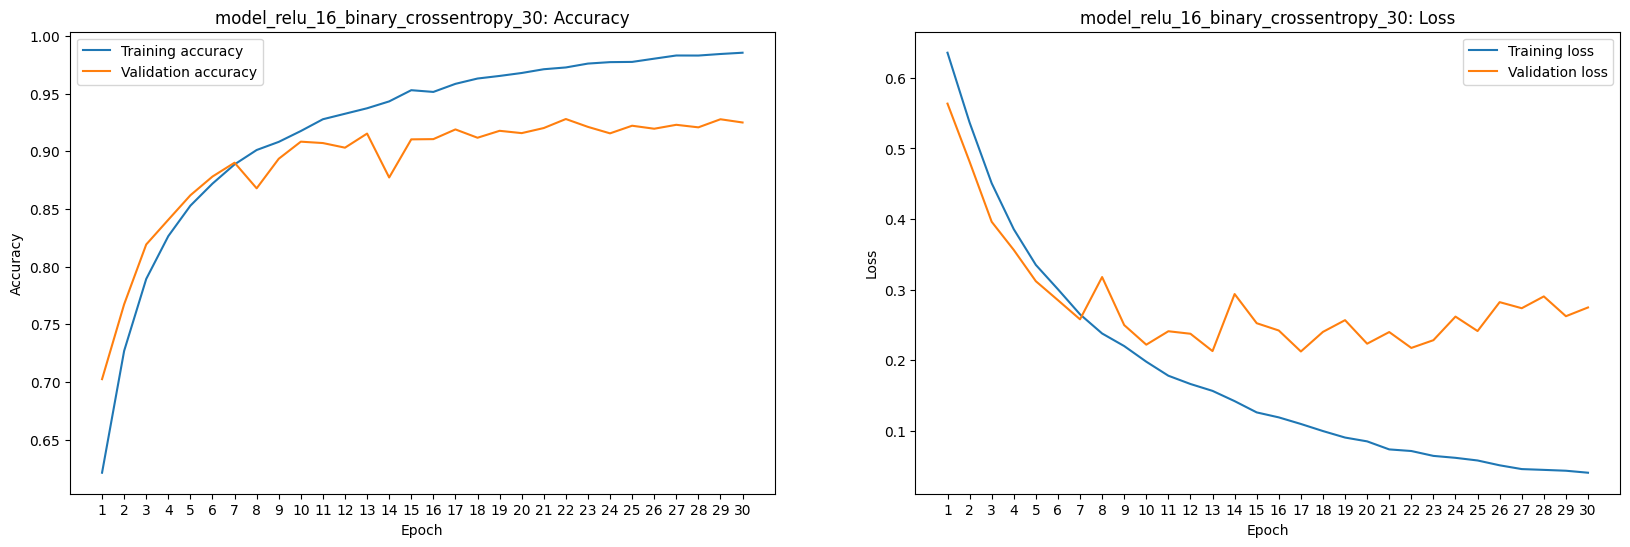

Model: model_relu_32_binary_crossentropy_30, best validation accuracy: 0.92791348695755


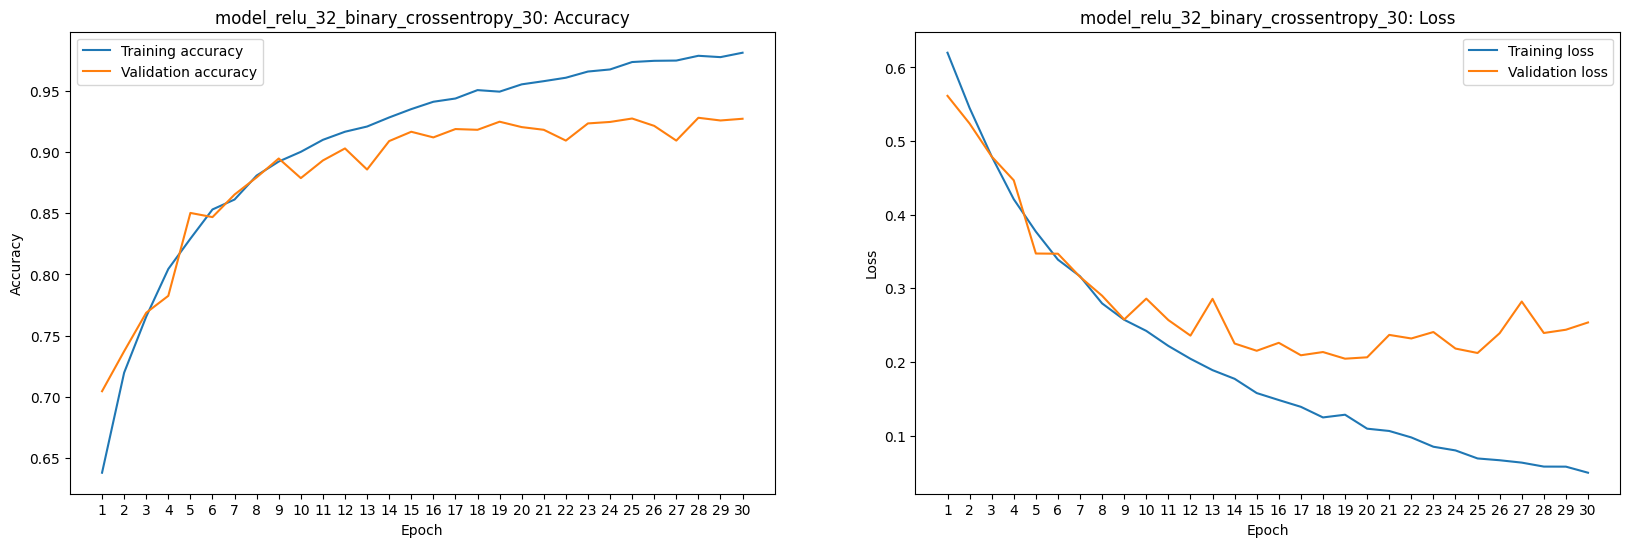

Model: model_relu_64_binary_crossentropy_30, best validation accuracy: 0.9283139705657959


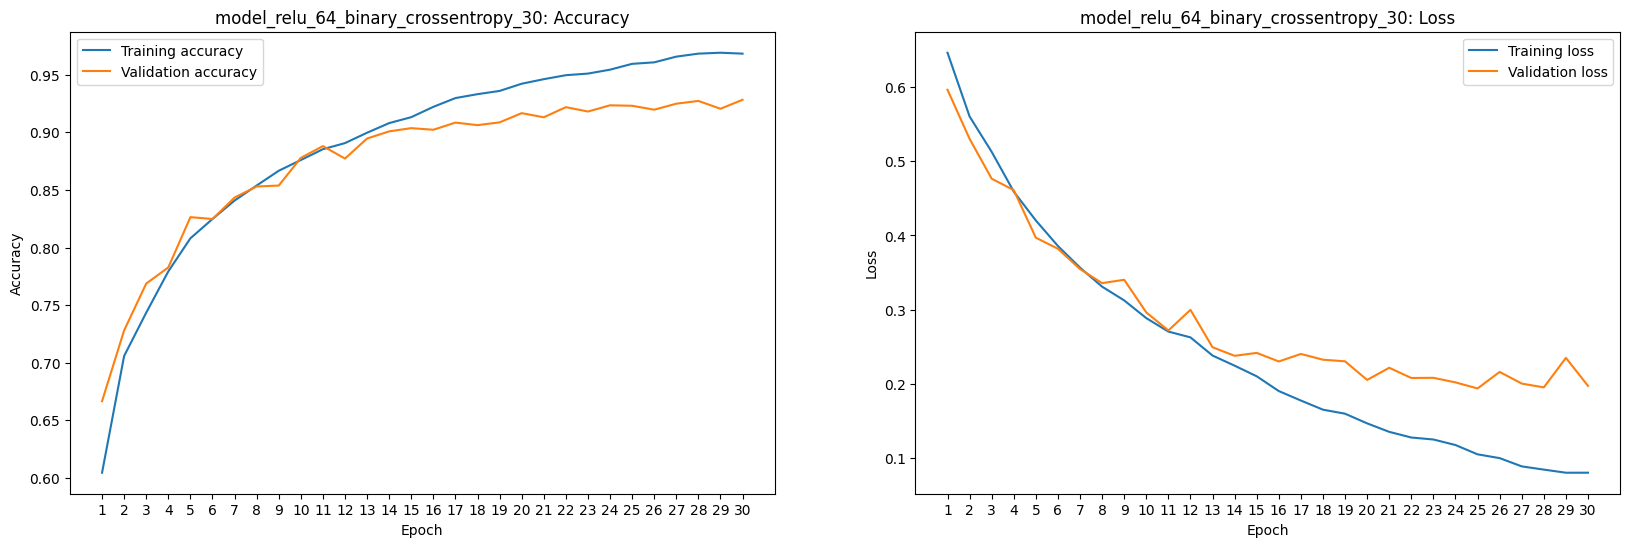

Model: model_sigmoid_16_binary_crossentropy_30, best validation accuracy: 0.5


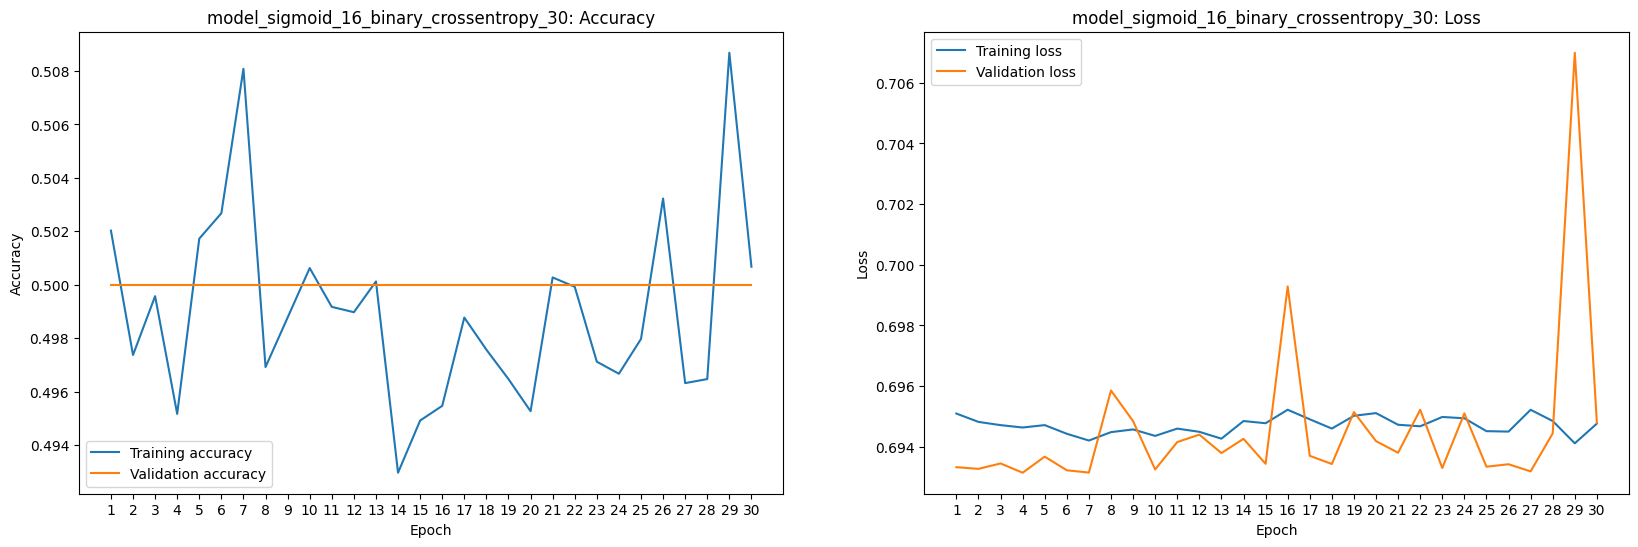

Model: model_sigmoid_32_binary_crossentropy_30, best validation accuracy: 0.5


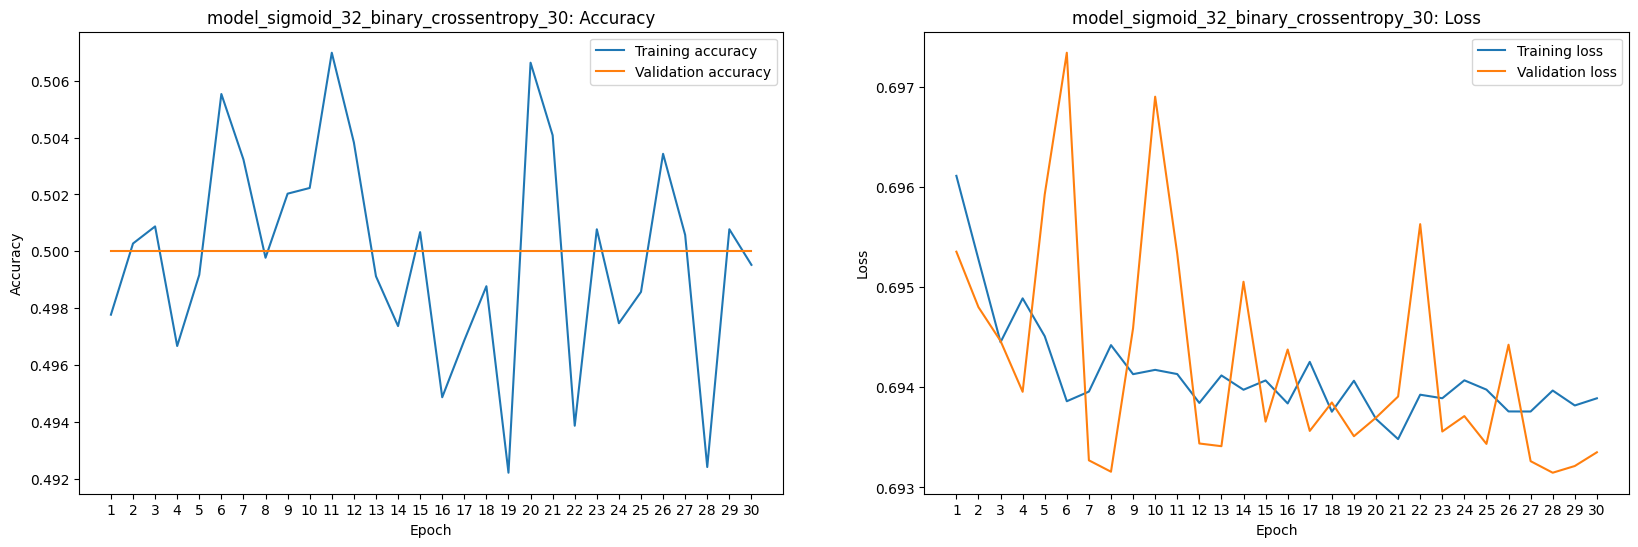

Model: model_sigmoid_64_binary_crossentropy_30, best validation accuracy: 0.5


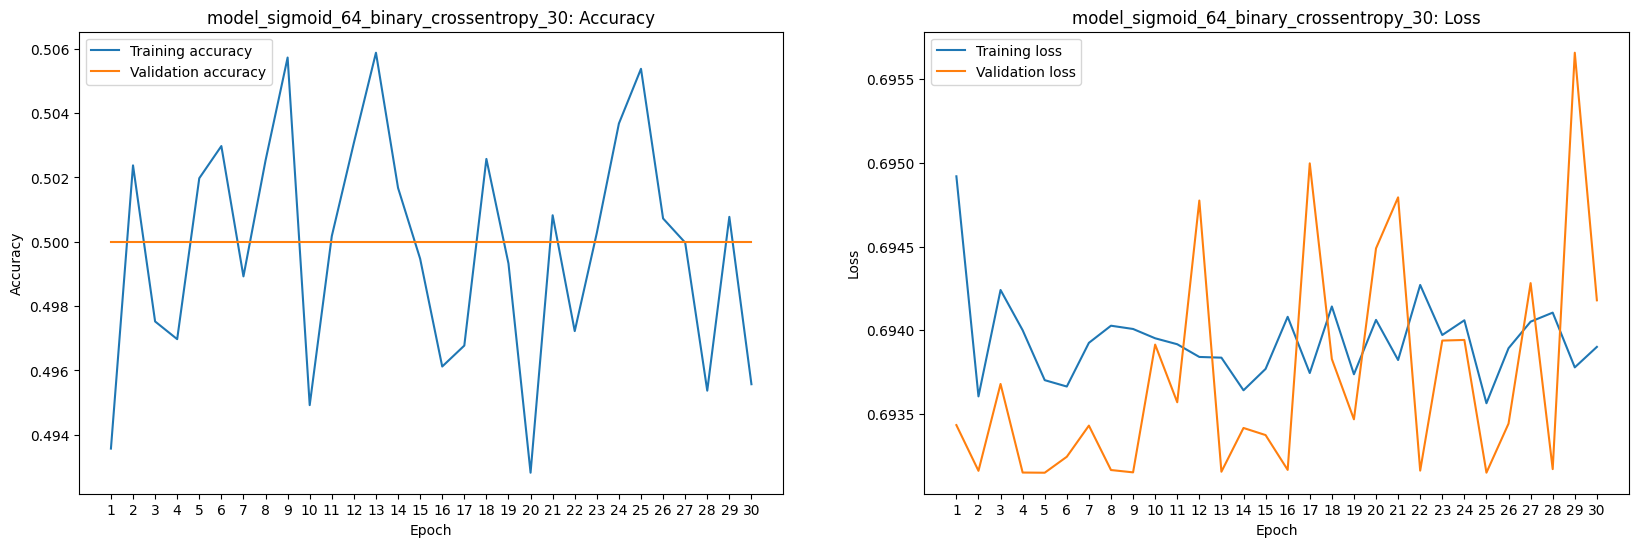

In [37]:
# best is: model_relu_64_binary_crossentropy_30

def plot_results_grid(results, save_dir='C:/dev/programming_2023/cnn_project/training_plots'):

    for i, result in enumerate(results):
        model_name = result['model_name']
        accuracy = result['accuracy']
        validation_accuracy = result['validation_accuracy']
        loss = result['loss']
        validation_loss = result['validation_loss']
        epochs = range(1, len(accuracy) + 1)
        
        print("Model: {}, best validation accuracy: {}".format(model_name, max(validation_accuracy)))

        fig, axes = plt.subplots(1, 2, figsize=(20, 6))

        # Plot accuracy
        axes[0].set_title(f"{model_name}: Accuracy")
        axes[0].plot(epochs, accuracy, label='Training accuracy')
        axes[0].plot(epochs, validation_accuracy, label='Validation accuracy')
        axes[0].set_xlabel("Epoch")
        axes[0].set_xticks(epochs)
        axes[0].set_ylabel("Accuracy")
        axes[0].legend()

        # Plot loss
        axes[1].set_title(f"{model_name}: Loss")
        axes[1].plot(epochs, loss, label='Training loss')
        axes[1].plot(epochs, validation_loss, label='Validation loss')
        axes[1].set_xlabel("Epoch")
        axes[1].set_xticks(epochs)
        axes[1].set_ylabel("Loss")
        axes[1].legend()

        # Save the figure
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        plt.show()
        fig.savefig(os.path.join(save_dir, f"{model_name}.png"))
        plt.close(fig)  # Close the figure to save memory

# Call the function with the results list
plot_results_grid(results)


# Appendix

In [ ]:
# LEGACY hardcodes candidate configs (pre random search)
candidate_architecture_configs = [
    # 2 convolutional layers, single dense layer
    [
        {"type": "Conv2D", "filters": 24, "kernel_size": (5, 5)},
        {"type": "MaxPooling2D", "pool_size": (2, 2)},
        {"type": "Conv2D", "filters": 48, "kernel_size": (5, 5)},
        {"type": "MaxPooling2D", "pool_size": (2, 2)},
        {"type": "Flatten"},
        {"type": "Dropout", "rate": 0.9},
        {"type": "Dense", "units": 2, "activation": "sigmoid"}
    ],
    # 3 convolutional layers, 2 dense layers (prev best)
    [
        {"type": "Conv2D", "filters": 24, "kernel_size": (5, 5)},
        {"type": "MaxPooling2D", "pool_size": (2, 2)},
        {"type": "Conv2D", "filters": 48, "kernel_size": (5, 5)},
        {"type": "MaxPooling2D", "pool_size": (2, 2)},
        {"type": "Conv2D", "filters": 128, "kernel_size": (5, 5)},
        {"type": "MaxPooling2D", "pool_size": (2, 2)},
        {"type": "Flatten"},
        {"type": "Dropout", "rate": 0.9},
        {"type": "Dense", "units": 64, "activation": "relu"},
        {"type": "Dense", "units": 2, "activation": "sigmoid"}
    ],
    # single conolutional layer, single dense layer
    [
        {"type": "Conv2D", "filters": 24, "kernel_size": (5, 5)},
        {"type": "MaxPooling2D", "pool_size": (2, 2)},
        {"type": "Flatten"},
        {"type": "Dropout", "rate": 0.9},
        {"type": "Dense", "units": 64, "activation": "relu"},
        {"type": "Dense", "units": 2, "activation": "sigmoid"}
    ],
    [
        # 3 convolutional layers, single dense layer
        {"type": "Conv2D", "filters": 24, "kernel_size": (5, 5)},
        {"type": "MaxPooling2D", "pool_size": (2, 2)},
        {"type": "Conv2D", "filters": 48, "kernel_size": (5, 5)},
        {"type": "MaxPooling2D", "pool_size": (2, 2)},
        {"type": "Conv2D", "filters": 96, "kernel_size": (5, 5)},
        {"type": "MaxPooling2D", "pool_size": (2, 2)},
        {"type": "Flatten"},
        {"type": "Dropout", "rate": 0.9},
        {"type": "Dense", "units": 2, "activation": "sigmoid"}
    ],
]


## Data Augmentation??

In [ ]:
TEST_CAT_DIR = r'C:\dev\programming_2023\cnn_project\test_cat'
        
first_images = os.listdir(TEST_CAT_DIR)[:20]
for image in first_images:
    test_img_path = "{}/{}".format(TEST_CAT_DIR, image)
    
    test_img =  cv2.cvtColor(cv2.imread(test_img_path), cv2.COLOR_BGR2RGB)
    
    # resize to  the net's inputs, normalize, and expant dims (for batch tensor)
    test_img = cv2.resize(test_img, (256, 256), interpolation=cv2.INTER_LINEAR)
    test_img = test_img.astype('float32') / 255.0
    test_img_expanded = np.expand_dims(test_img, axis=0)
    
    print(np.shape(test_img_expanded))
    break

    class_probabilities = model.predict(test_img_expanded)
    
    plt.imshow(test_img)
    plt.show()
    


In [ ]:
TEST_DOG_DIR = r'C:\dev\programming_2023\cnn_project\test_dog'
        
first_images = os.listdir(TEST_DOG_DIR)
for image in first_images:
    test_img_path = "{}/{}".format(TEST_DOG_DIR, image)
    
    test_img =  cv2.cvtColor(cv2.imread(test_img_path), cv2.COLOR_BGR2RGB)
    
    # resize to  the net's inputs, normalize, and expant dims (for batch tensor)
    test_img = cv2.resize(test_img, (256, 256), interpolation=cv2.INTER_LINEAR)
    test_img = test_img.astype('float32') / 255.0
    test_img_expanded = np.expand_dims(test_img, axis=0)
    
    print(np.shape(test_img_expanded))

    class_probabilities = model.predict(test_img_expanded)
    print("cat: {} dog: {}".format(class_probabilities[0][0], class_probabilities[0][1]))
    
    plt.imshow(test_img)
    plt.show()